In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd


# Data Preparation

In [2]:
transformer = transforms.Compose([
  transforms.ToTensor()
])

dataset = ImageFolder("../input/traffic-signs-classification/myData")
validation_split = 0.2
random_seed = 11
dataset_size = len(dataset)
classes = len(set(dataset.targets)) 
indices = list(range(dataset_size))
split = int(np.floor(dataset_size * validation_split))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

class map_transform(Dataset):
  def __init__(self, dataset, map_fn):
    self.dataset = dataset
    self.map_fn = map_fn

  def __getitem__(self, index):
    return self.map_fn(self.dataset[index][0]), self.dataset[index][1]

  def __len__(self):
    return len(self.dataset)

train_transformer = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor()
])

val_transformer = transforms.ToTensor()

train_dataset = map_transform(train_dataset, train_transformer)
val_dataset = map_transform(val_dataset, val_transformer)

batch_size = 128
train_loader = DataLoader(dataset= train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset= val_dataset, batch_size=batch_size)


# The CNN Model

In [3]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=2, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=5, padding=2, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 256),
    nn.ReLU(),
    nn.Linear(256, classes)
)

# Training the model on the data

In [4]:
device = torch.device("cuda:0")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [5]:
epocs = 8
train_losses = np.zeros(epocs)
test_losses = np.zeros(epocs)
for i in range(epocs):
  d0 = datetime.datetime.now()
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  
  train_losses[i] = np.mean(train_loss)
  test_loss = []
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())

  test_losses[i] = np.mean(test_loss)
  dt = datetime.datetime.now() - d0
  print(f"epoc {i+1}/{epocs}, train loss={train_losses[i]}, test loss={test_losses[i]}, duration={dt}")

epoc 1/8, train loss=0.6182485099345055, test loss=0.13664013134396594, duration=0:04:40.622693
epoc 2/8, train loss=0.09560094279639715, test loss=0.06270517161035019, duration=0:02:13.022495
epoc 3/8, train loss=0.05693824705616957, test loss=0.033152150664397556, duration=0:02:06.175625
epoc 4/8, train loss=0.04765240271007907, test loss=0.043527580616469295, duration=0:02:04.633301
epoc 5/8, train loss=0.04063943562765838, test loss=0.05815580166957301, duration=0:02:03.379741
epoc 6/8, train loss=0.04967270829657898, test loss=0.03741467901272699, duration=0:02:08.356248
epoc 7/8, train loss=0.028460264324206643, test loss=0.04578661942328124, duration=0:02:06.747502
epoc 8/8, train loss=0.03062990854680335, test loss=0.0244111008236043, duration=0:02:05.840618


# Model accuracy on Validation set

In [6]:
n_corrects = 0
n_total = 0
for inputs, targets in val_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  _,pred = torch.max(outputs, 1)
  n_corrects += (pred == targets).sum().item()
  n_total += targets.shape[0]
  
acc = (n_corrects/n_total)*100
print(round(acc, 3))

99.193


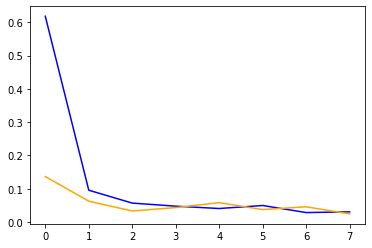

In [7]:
plt.plot(np.arange(epocs), train_losses, color='blue')
plt.plot(np.arange(epocs), test_losses, color='orange')

In [8]:
torch.save(model.state_dict(), "model.pt")